In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

In [2]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [4]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [5]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [6]:
# Don't understand what the y_train[0] indices are of? It seems like they only go up to
# the length of labtrans.cuts but I don't understand what the discretization grid that is 
# in labtrans.cuts is all about. 
labtrans.cuts[y_train[0]]



array([ 78.933334, 118.4     , 236.8     , ...,  39.466667, 197.33334 ,
       118.4     ], dtype=float32)

In [7]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [8]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
0:	[0s / 0s],		train_loss: 2.9263,	val_loss: 2.7659
1:	[0s / 0s],		train_loss: 2.6603,	val_loss: 2.5461
2:	[0s / 0s],		train_loss: 2.3791,	val_loss: 2.2354
3:	[0s / 0s],		train_loss: 2.0756,	val_loss: 1.9005
4:	[0s / 0s],		train_loss: 1.7898,	val_loss: 1.5965
5:	[0s / 0s],		train_loss: 1.5691,	val_loss: 1.4399
6:	[0s / 0s],		train_loss: 1.4533,	val_loss: 1.3834
7:	[0s / 0s],		train_loss: 1.4080,	val_loss: 1.3732
8:	[0s / 0s],		train_loss: 1.3977,	val_loss: 1.3749
9:	[0s / 0s],		train_loss: 1.3683,	val_loss: 1.3710
10:	[0s / 0s],		train_loss: 1.3406,	val_loss: 1.3672
11:	[0s / 0s],		train_loss: 1.3476,	val_loss: 1.3632
12:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.3599
13:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.3536
14:	[0s / 0s],		train_loss: 1.3253,	val_loss: 1.3544
15:	[0s / 0s],		train_loss: 1.3170,	val_loss: 1.3566
16:	[0s / 0s],		train_loss: 1.3101,	val_loss: 1.3618
17:	[0s / 0s],		train_loss: 1.3191,	val_loss: 1.364

In [9]:
print(type(val)) # , y_train, batch_size, epochs, callbacks, val)
print(val)

<class 'tuple'>
(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
         0.        ,  1.        ],
       [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
         0.        ,  1.        ],
       [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
         0.        ,  1.        ],
       [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32), (array([3, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 1, 5, 3, 2, 1, 5, 3, 4, 0, 2, 5,
       7, 5, 4, 3, 2, 4, 5, 6, 1, 1, 3, 7, 1, 1, 4, 2, 4, 6, 6, 1, 3, 6,
       2, 2, 4, 1, 2, 3, 4, 2, 2, 5, 4, 1, 1, 3, 6, 1, 5, 2, 3, 6, 2, 5,
       3, 2, 5, 4, 4, 4, 2, 1, 3, 2, 5, 2, 8, 4, 1, 2, 2, 2, 3, 2, 4, 1,
       3, 3, 1, 2, 3, 1, 5, 2, 6, 2, 3, 3, 5, 2, 6, 2, 4, 5, 

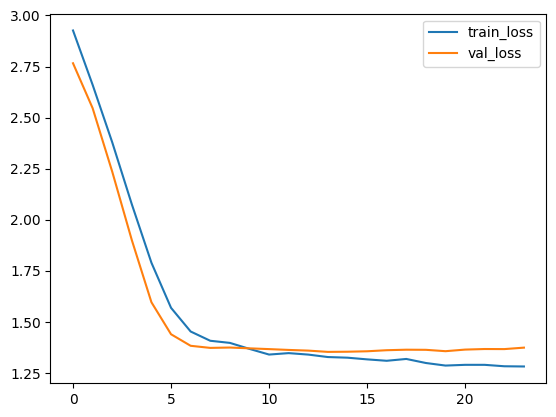

In [10]:
_ = log.plot()


In [11]:
log.to_pandas().val_loss.min()
model.score_in_batches(val)


{'loss': 1.3536216020584106}

In [1]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
surv

NameError: name 'model' is not defined

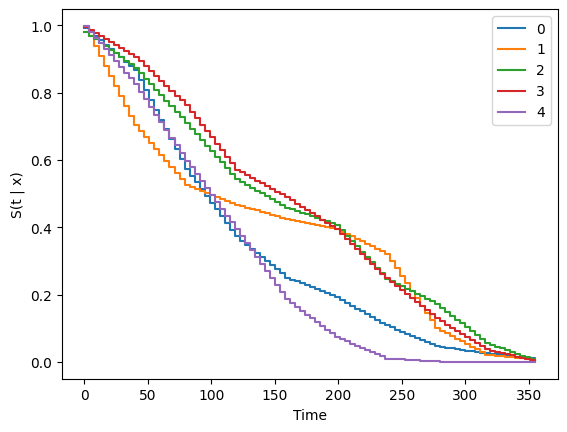

In [13]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


In [14]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
# ev.concordance_td('antolini')


In [15]:
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# ev.brier_score(time_grid).plot()
# plt.ylabel('Brier score')
# _ = plt.xlabel('Time')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

: 